In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from augur.utils import json_to_tree
import json
import math

# Grabbing accumulated mutations for each variant

In [2]:
import json
from augur.utils import json_to_tree

In [3]:
# starting node
END_NODE = 'BA.2'

#grab lineage of tip node
def find_lineage(tree, child_node, rows_for_tsv):
    gene_muts = {}
    node_path = tree.get_path(child_node)
    i = len(node_path) - 1
    while (i >= 0 and END_NODE not in node_path[i].name):
        i = i - 1
        gene_muts = format_string(node_path[i].branch_attrs['mutations'],'nuc', gene_muts)
    #append variant name, mutation, and region to list
    for k in gene_muts.keys():
        for j in range(len(gene_muts[k])):
            temp_dict = gene_muts[k]
            mut =  str(temp_dict[j]) + '_' + str(k)
            rows_for_tsv.append({'variant': child_node.name, 'mutation': mut})

#put all the same gene mutations in the same list
def format_string(dict, key, gene_muts):
    for k in dict.keys():
        if (str(k) != key):
            if k not in gene_muts.keys():
                gene_muts[k] = []
            for j in range(len(dict[k])):
                temp_dict = dict[k]
                gene_muts[k].append(temp_dict[j])
    return gene_muts

if __name__ == '__main__':
    #read in tree
    with open(f'../mutations-by-variant/pango_lineages.json', 'r') as f:
        tree_json = json.load(f)
    #put tree in Bio.Phylo format
    tree = json_to_tree(tree_json)
    #create list of dictionaries for dataframe
    rows_for_tsv = []
    for tip in tree.find_clades(terminal=True):
        #append new row for every mutation in every child node
        find_lineage(tree, tip, rows_for_tsv)
    #make pandas dataframe from list of dicts
    accumulated_mutations = pd.DataFrame(rows_for_tsv)

In [4]:
#viewing accumulated mutations df
accumulated_mutations

,variant,mutation
0,XA,S3L_E
1,XA,S6L_E
2,XA,T9I_E
3,XA,T11M_E
4,XA,L18F_E
...,...,...
419888,CK.2.1.1,S33X_N
419889,CK.2.1.1,*420X_N
419890,CK.2.1.1,R203K_N
419891,CK.2.1.1,G204R_N


# Assigning Mutational GAs to each variant

In [25]:
import jax.numpy as jnp
import numpy as np
import evofr as ef
from evofr.models.mutational_fitness_mlr import MutationalFitnessMLR, MutationalFitnessSequenceCounts

In [63]:
# Getting data
raw_seq = pd.read_csv("../../sars2-epistasis-modeling/count-data/pango_location-variant-sequence-counts.tsv", sep="\t")
raw_seq = raw_seq[~raw_seq.variant.str.startswith("X")]
raw_muts = accumulated_mutations
variant_frequencies = MutationalFitnessSequenceCounts(raw_seq, raw_muts)

In [64]:
# Defining model
mlr = MutationalFitnessMLR(tau=4.2)
# Defining inference method
inference_method = ef.InferMAP(iters=100_000, lr=4e-4)
# Fitting model
posterior = inference_method.fit(mlr, variant_frequencies)
samples = posterior.samples

In [65]:
# defining the growth advantages
mut_ga = pd.DataFrame(
    ef.posterior.get_growth_advantage(samples, posterior.data, ps=[0.8], name="USA", rel_to="BA.2")
)

In [66]:
#viewing mutational ga df
mut_ga

,location,variant,median_ga,ga_upper_80,ga_lower_80
0,USA,B.1.1.529,1.0,1.0,1.0
1,USA,BA.1,0.6318243,0.6318243,0.6318243
2,USA,BA.1.1,0.6560716,0.6560716,0.6560716
3,USA,BA.1.1.1,0.6540526,0.6540526,0.6540526
4,USA,BA.1.1.10,0.72829163,0.72829163,0.72829163
...,...,...,...,...,...
173,USA,BQ.1.14,0.16171543,0.16171543,0.16171543
174,USA,BQ.1.2,0.1205304,0.1205304,0.1205304
175,USA,BQ.1.3,1.5643382,1.5643382,1.5643382
176,USA,BQ.1.6,0.12053034,0.12053034,0.12053034


# Assigning individual fitnesses to each mutation

In [67]:
# Grabbing fitness for each mutation, in sorted order
def mutations(samples, data):
    rows_for_tsv = []
    delta = jnp.median(samples["raw_delta"], axis=0)
    idx = (-delta).argsort()[:len(delta)]
    for i in idx:
        array = delta[i]
        rows_for_tsv.append({'mutation':data.mut_names[i], 'fitness_effect':array})
    return rows_for_tsv
table = mutations(samples, variant_frequencies)
mutations_table = pd.DataFrame(table)

In [80]:
# creating summary table with variant name, variant ga, mutation, mutation fitness
final_table = pd.merge(mut_ga, raw_muts, on="variant")
final_table = pd.merge(final_table, mutations_table, on="mutation")
final_table = final_table.drop(final_table.columns[0], axis=1)
final_table = final_table.drop(final_table.columns[2], axis=1)
final_table = final_table.drop(final_table.columns[2], axis=1)
# renaming the table
mutations_summary = final_table

In [81]:
# viewing table of mutation fitnesses
mutations_summary

,variant,median_ga,mutation,fitness_effect
0,BA.1,0.6318243,D3G_M,-0.70717216
1,BA.1.1,0.6560716,D3G_M,-0.70717216
2,BA.1.1.1,0.6540526,D3G_M,-0.70717216
3,BA.1.1.10,0.72829163,D3G_M,-0.70717216
4,BA.1.1.14,0.671621,D3G_M,-0.70717216
...,...,...,...,...
11574,BQ.1.13,0.12053037,V627I_ORF1a,-0.0699849
11575,BQ.1.2,0.1205304,I666V_S,-0.06998489
11576,BQ.1.3,1.5643382,E619Q_S,0.30067372
11577,BQ.1.3,1.5643382,L3293I_ORF1a,0.23965493


# Assigning innovation GA to variants

In [41]:
# Getting data
raw_seq = pd.read_csv("../count-data/pango_location-variant-sequence-counts.tsv", sep="\t")
# raw_variant_parents is missing a row for BA.2, so append one
raw_variant_parents = pd.concat((pd.read_csv("../count-data/pango_variant-relationships.tsv", sep="\t"),
                                pd.DataFrame({"variant": ["BA.2"], "parent": ["base"]}))).reset_index(drop=True)
variant_frequencies = ef.InnovationSequenceCounts(raw_seq, raw_variant_parents, pivot="BA.2")

In [42]:
innovation_ga = pd.DataFrame(
    ef.posterior.get_growth_advantage(samples, posterior.data, ps=[0.8], name="USA", rel_to="BA.2")
)

In [43]:
#viewing innovation ga df
innovation_ga

,location,variant,median_ga,ga_upper_80,ga_lower_80
0,USA,B.1.1.529,1.0,1.0,1.0
1,USA,BA.1,0.6318243,0.6318243,0.6318243
2,USA,BA.1.1,0.6560716,0.6560716,0.6560716
3,USA,BA.1.1.1,0.6540526,0.6540526,0.6540526
4,USA,BA.1.1.10,0.72829163,0.72829163,0.72829163
...,...,...,...,...,...
173,USA,BQ.1.14,0.16171543,0.16171543,0.16171543
174,USA,BQ.1.2,0.1205304,0.1205304,0.1205304
175,USA,BQ.1.3,1.5643382,1.5643382,1.5643382
176,USA,BQ.1.6,0.12053034,0.12053034,0.12053034


# Comparing Innovation and Mutational Growth Advantages

In [51]:
# resolving weird formatting issues btwn csv and loading pandas df??
mut_ga.to_csv('mut_ga.tsv', sep="\t")
innovation_ga.to_csv('innov_ga.tsv', sep="\t")

In [52]:
# loading in datasets
parent_variant_relationships = pd.read_csv("../count-data/pango_variant-relationships.tsv", sep="\t").set_index("variant")
mut_ga = pd.read_csv("mut_ga.tsv", sep="\t")
innovation_ga = pd.read_csv("innov_ga.tsv", sep="\t")

In [53]:
# Prep to merge
def clean_and_merge(innovation_ga, mut_ga, parent_variant_relationships):
    innovation_ga = (innovation_ga
                     .rename(columns={"median_ga": "innov-ga"})
                     [["variant", "innov-ga"]])

    mut_ga = (mut_ga
              .rename(columns={"median_ga": "mut-ga"})
              [["variant", "mut-ga"]])

    ga_df = innovation_ga.merge(mut_ga, how="right").set_index("variant")
    ga_df["mut-ga"] = ga_df["mut-ga"] / ga_df.loc["BA.2.1"]["mut-ga"] # Scale GA by BA.2.1

    # Add parents
    def _get_parent(row):
        variant = row.name
        if variant in parent_variant_relationships.index:
            return parent_variant_relationships.loc[variant]
        return "NAN"

    ga_df["parent"] = ga_df.apply(_get_parent, axis=1)
    return ga_df

In [54]:
ga_df = clean_and_merge(innovation_ga, mut_ga, parent_variant_relationships)

In [55]:
# Look for parent for mut-parent-ga
def add_deltas(row, prefix):
    # Give up if parent not found
    if row.parent not in ga_df.index:
        return pd.Series([np.nan, np.nan],
                         index=[prefix + "-parent-ga", prefix + "-pc-ratio"])
    # Get child growth advantage
    parent_row = ga_df.loc[row.parent]
    
    # Return parent ga and ratio
    return pd.Series([parent_row[prefix + "-ga"],  row[prefix + "-ga"] / parent_row[prefix + "-ga"]],
                         index=[prefix + "-parent-ga", prefix + "-pc-ratio"])
    
ga_df[["mut-parent-ga", "mut-pc-ratio"]] = ga_df.apply(add_deltas, prefix="mut", axis=1)
ga_df[["innov-parent-ga", "innov-pc-ratio"]] = ga_df.apply(add_deltas, prefix="innov", axis=1)

In [56]:
def is_outlier_IQR(data, col, scale=1.5):
    """
    Find wheter outliers in column col from dataframe data
    Uses IQR rule based on normal approximation.
    """

    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
    lower_bound = Q1 - scale * IQR
    upper_bound = Q3 + scale * IQR
    return (data[col] < lower_bound) | (data[col] > upper_bound)

    
ga_df["innov-mut-ratio"] = ga_df["innov-ga"] / ga_df["mut-ga"]
ga_df["log-innov-mut-ratio"] = np.log(ga_df["innov-ga"] / ga_df["mut-ga"])
ga_df["outlier"] = is_outlier_IQR(ga_df, "log-innov-mut-ratio") # log-innov-mut-ratio ~ Normal()

## Plotting mutational ga vs. innovation ga

Each datapoint is a variant. Red datapoints are variants in which the rato between innovation/mutational ga is considered an outlier. Therefore, red variants might indicate epistasis where blue datapoint variants would indicate no epistasis. 

Text(0, 0.5, 'Mutation GA')

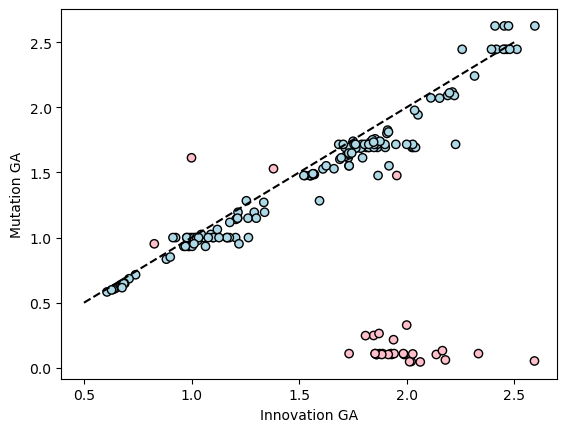

In [57]:
# Coloring by outlier
plt.scatter(ga_df["innov-ga"], ga_df["mut-ga"], 
            color=["pink" if value else "lightblue" for value in ga_df.outlier], 
            ec="k")
plt.plot([0.5, 2.5], [0.5, 2.5], color="k", linestyle="--")
plt.xlabel("Innovation GA")
plt.ylabel("Mutation GA")

# Looking at Outliers

In [58]:
# Defining outliers
outliers = ga_df[ga_df.outlier & (ga_df["mut-pc-ratio"] < 0.5)]

In [59]:
# Looking at outliers in bottom right with low ga
outliers

,innov-ga,mut-ga,parent,mut-parent-ga,mut-pc-ratio,innov-parent-ga,innov-pc-ratio,innov-mut-ratio,log-innov-mut-ratio,outlier
variant,,,,,,,,,,
BA.5.1.21,1.846614,0.248369,BA.5.1,1.692330,0.146762,1.784575,1.034764,7.434960,2.006193,True
BA.5.10.1,2.000346,0.328307,BA.5,1.692330,0.193997,1.771832,1.128971,6.092916,1.807127,True
BA.5.2.16,1.930347,0.102519,BA.5.2,1.715751,0.059752,1.862826,1.036247,18.829140,2.935406,True
BA.5.2.19,1.927386,0.109233,BA.5.2,1.715751,0.063665,1.862826,1.034657,17.644788,2.870440,True
BA.5.2.2,1.732573,0.109233,BA.5.2,1.715751,0.063665,1.862826,0.930077,15.861318,2.763883,True
BA.5.2.20,1.874296,0.109233,BA.5.2,1.715751,0.063665,1.862826,1.006157,17.158768,2.842509,True
BA.5.2.21,1.854681,0.109233,BA.5.2,1.715751,0.063665,1.862826,0.995627,16.979192,2.831989,True
BA.5.2.22,1.941731,0.109233,BA.5.2,1.715751,0.063665,1.862826,1.042358,17.776117,2.877856,True
BA.5.2.24,2.137971,0.102519,BA.5.2,1.715751,0.059752,1.862826,1.147703,20.854358,3.037563,True


# Verifying Outlier Mutational GA Assignments

Given that:

    relative_fitness_variant = sum(mutational_fitness for mutation in variant)
    mutational_ga_variant = exp(relative_fitness_variant * generation_time)
    generation_time is fixed at 4.2

The calculated_ga variable for each variant is assigned using the equation above. 

In [87]:
# compiling outlier summary table with indv fitnesses and mutational ga

# just looking at outliers for now
outlier_variants = ga_df[ga_df["outlier"]].index
# group by variants
grouped = mutations_summary.groupby('variant')
# final df
rows_for_tsv = []
for name, group in grouped:
    if name in outlier_variants:
        variant_dict = {}
        mutations = group['mutation']
        variant_dict['variant'] = name
        mut_ga = group['median_ga'].iloc[0]
        variant_dict['mut_ga'] = mut_ga
        cum_sum = 0
        for m in mutations:
            # grabbing the fitness effect  of each mutation
            fitness_effect = group.loc[group['mutation'] == m, 'fitness_effect'].iloc[0]
            variant_dict[m] = fitness_effect
            # summing up all mutation fitnesses
            cum_sum += fitness_effect
        # multiply by generation time and raise e to this number
        calculated_ga = math.exp(cum_sum * 4.2)
        variant_dict['calculated_ga'] = calculated_ga
        variant_dict['match'] = (mut_ga == calculated_ga)
        rows_for_tsv.append(variant_dict)
resulting_table = pd.DataFrame(rows_for_tsv)      

In [93]:
#aesthetic changes to the summary df

# moving mut_ga to end 
cols_at_end = ['calculated_ga', 'mut_ga', 'match']
resulting_table = resulting_table[[c for c in resulting_table if c not in cols_at_end] 
        + [c for c in cols_at_end if c in resulting_table]]
# concatenating innovation ga column info 
trimmed = ga_df[ga_df["outlier"]].drop(columns=['mut-ga','parent','mut-parent-ga','mut-pc-ratio','innov-parent-ga','innov-pc-ratio','innov-mut-ratio','log-innov-mut-ratio','outlier'])
merged = pd.merge(resulting_table, trimmed, on="variant", how="left")
resulting_table = merged

In [94]:
# viewing mutational fitnesses for outliers
resulting_table

,variant,Q19E_M,A63T_M,P3395H_ORF1a,S3675-_ORF1a,G3676-_ORF1a,T3255I_ORF1a,A67V_S,H69-_S,V70-_S,...,T11A_E,S1221L_ORF1a,P1640S_ORF1a,N4060S_ORF1a,F490S_S,K356T_S,calculated_ga,mut_ga,match,innov-ga
0,BA.4.1.9,-0.319244,0.09438059,0.010739697,-0.025923524,-0.47657436,-0.0037472262,0.16476332,-0.07814602,0.33205706,...,NaN,NaN,NaN,NaN,NaN,NaN,0.009498,0.003269428,False,1.954345
1,BA.5.1.21,-0.319244,0.09438059,0.010739697,-0.025923524,-0.47657436,-0.0037472262,0.16476332,-0.07814602,0.33205706,...,NaN,NaN,NaN,NaN,NaN,NaN,0.059920,0.020626668,False,1.846614
2,BA.5.10.1,-0.319244,0.09438059,0.010739697,-0.025923524,-0.47657436,-0.0037472262,0.16476332,-0.07814602,0.33205706,...,NaN,NaN,NaN,NaN,NaN,NaN,0.155820,0.053638805,False,2.000346
3,BA.5.2.16,-0.319244,0.09438059,0.010739697,-0.025923524,-0.47657436,-0.0037472262,0.16476332,-0.07814602,0.33205706,...,NaN,NaN,NaN,NaN,NaN,NaN,0.004758,0.0016379224,False,1.930347
4,BA.5.2.19,-0.319244,0.09438059,0.010739697,-0.025923524,-0.47657436,-0.0037472262,0.16476332,-0.07814602,0.33205706,...,NaN,NaN,NaN,NaN,NaN,NaN,0.004758,0.0016379232,False,1.927386
5,BA.5.2.2,-0.319244,0.09438059,0.010739697,-0.025923524,-0.47657436,-0.0037472262,0.16476332,-0.07814602,0.33205706,...,NaN,NaN,NaN,NaN,NaN,NaN,0.004567,0.0015721677,False,1.732573
6,BA.5.2.20,-0.319244,0.09438059,0.010739697,-0.025923524,-0.47657436,-0.0037472262,0.16476332,-0.07814602,0.33205706,...,NaN,NaN,NaN,NaN,NaN,NaN,0.004963,0.0017082794,False,1.874296
7,BA.5.2.21,-0.319244,0.09438059,0.010739697,-0.025923524,-0.47657436,-0.0037472262,0.16476332,-0.07814602,0.33205706,...,NaN,NaN,NaN,NaN,NaN,NaN,0.004963,0.0017082794,False,1.854681
8,BA.5.2.22,-0.319244,0.09438059,0.010739697,-0.025923524,-0.47657436,-0.0037472262,0.16476332,-0.07814602,0.33205706,...,NaN,NaN,NaN,NaN,NaN,NaN,0.004758,0.001637924,False,1.941731
9,BA.5.2.24,-0.319244,0.09438059,0.010739697,-0.025923524,-0.47657436,-0.0037472262,0.16476332,-0.07814602,0.33205706,...,NaN,NaN,NaN,NaN,NaN,NaN,0.004758,0.0016379224,False,2.137971


## Outstanding Questions

The calculated ga and assigned mutational ga should match for each variant. As seen above, none of them do. What is going on?